# CS271: Sentiment Analysis using Machine Learning and Deep Learning 

# IMDB dataset

In [0]:

import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, re

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder

In [12]:

# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
  data = {}
  data["sentence"] = []
  data["sentiment"] = []
  for file_path in os.listdir(directory):
    with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
      data["sentence"].append(f.read())
      data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
  return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
  pos_df = load_directory_data(os.path.join(directory, "pos"))
  neg_df = load_directory_data(os.path.join(directory, "neg"))
  pos_df["polarity"] = 1
  neg_df["polarity"] = 0
  return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
  dataset = tf.keras.utils.get_file(
      fname="aclImdb.tar.gz", 
      origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
      extract=True)

  train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
  test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))

  return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

sentence sentiment  polarity
0  I can hardly believe that this inert, turgid a...         4         0
1  the acting itself wasn't even that bad, since ...         2         0
2  I was unsure whether or not Andy Sidaris could...         2         0
3  Really, I can't believe that I spent $5 on thi...         3         0
4  The Rookie is based on the true story of a 40+...         8         1

In [13]:
train = train_df.sample(1000)
test = test_df.sample(1000)
DATA_COLUMN = 'sentence'
LABEL_COLUMN = 'polarity'
label_list = [0, 1] # [negative, positive]
Train_X = train[DATA_COLUMN]
Test_X = test[DATA_COLUMN]
Train_Y = train[LABEL_COLUMN]
Test_Y = test[LABEL_COLUMN] 
print(Train_X.shape)

(1000,)


# [1] BERT Model Fine-Tuning (Contextualized Word Embeddings)

*   TestSet Accuracy = 87%
*   Stamp Review Set Inferene Accuracy = 75%


In [7]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.4MB/s 


In [0]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [0]:
train_InputExamples = train.apply(
    lambda x: bert.run_classifier.InputExample(guid=None,
    text_a = x[DATA_COLUMN], text_b = None, label = x[LABEL_COLUMN]), axis = 1)
test_InputExamples = test.apply(
    lambda x: bert.run_classifier.InputExample(guid=None, 
    text_a = x[DATA_COLUMN], text_b = None, label = x[LABEL_COLUMN]), axis = 1)

In [0]:
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)


In [0]:
tokenizer = create_tokenizer_from_hub_module()

In [0]:
# each given sentence should have upto 128 tokens (mostly less than that)
MAX_SEQ_LENGTH = 128
# Convert train/test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features\
(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(\
test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

In [0]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(BERT_MODEL_HUB, trainable=True)
  bert_inputs = dict(input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids)
  bert_outputs = bert_module(inputs=bert_inputs, signature="tokens", as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create fine-tune layer 
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)
    

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)
      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg
        }
      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [0]:
# These hyperparameters are copied from this colab notebook 
#(https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [33]:
OUTPUT_DIR = 'SA_OUTPUT_TPU'
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: SA_OUTPUT_TPU *****


In [0]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [0]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [45]:
from datetime import datetime
print('Beginning Fine-Tuning!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
elapse=(datetime.now() - current_time)
print("Fine-Tuning Time in minutes ", elapse//60)

Beginning Fine-Tuning!


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fine-Tuning Time in minutes  0:00:01.639143


In [0]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

##Model Evaulation

In [47]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


{'auc': 0.8708271,
 'eval_accuracy': 0.869,
 'f1_score': 0.86991054,
 'false_negatives': 87.0,
 'false_positives': 44.0,
 'global_step': 93,
 'loss': 0.39820394,
 'precision': 0.9087137,
 'recall': 0.83428574,
 'true_negatives': 431.0,
 'true_positives': 438.0}

In [0]:
def getPrediction(in_sentences):
  labels = ["Negative", "Positive"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)  
  return [(sentence, prediction['probabilities'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)]


In [56]:
f = open("StampReview_label.txt", "r") 
labels = ["Negative", "Positive"]
sentences = []
sentiments = []
for line in f.readlines():
  line = line.rstrip()
  sentiments.append(line.split('@')[0])
  sentences.append(line.split('@')[1])
print(sentiments[0], sentences[0])

1 Excellent knowledge and teaching strategies. Good use of previous student work as practical examples for the applications.


## Prof. Stamp Review Inference


In [0]:
predictions = getPrediction(sentences)
pred_Y = [0 if p[2] is 'Negative' else 1 for p in predictions]
sentences = [p[0] for p in predictions]

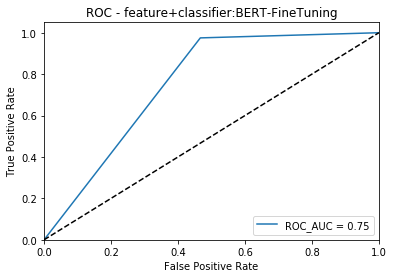

TN=8| FP=7
FN=1| TP=39

False Positives
This class was almost overwhelming in terms of the amount of time it demanded, certainly for the number of credits it's worth.
Assignments could be a tad easier.
More jokes!
Please give lesser homework.
Not too approachable.
Homework is very intellectually challenging.
Assignment in which we had to create a virus was really tough.

False Negatives
Non-comprehensive final. A+++++


In [66]:
GT_Y = LabelEncoder().fit_transform(sentiments)
fpr, tpr, _ = roc_curve(GT_Y, pred_Y)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC_AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC - feature+classifier:BERT-FineTuning')
plt.show()

cm = confusion_matrix(GT_Y, pred_Y)
print("TN=%d| FP=%d" % (cm[0][0],cm[0][1]))
print("FN=%d| TP=%d" % (cm[1][0],cm[1][1]))
FPs=[]
FNs=[]
for i in range(len(GT_Y)):
  if GT_Y[i] != pred_Y[i]:
    if GT_Y[i]==0:
      FPs.append(sentences[i])
    else:
      FNs.append(sentences[i])
print("\nFalse Positives\n=================")
print('\n'.join(FPs))
print("\nFalse Negatives\n=================")
print('\n'.join(FNs))


# [2] Feature: TF-IDF 

*   Naive-Bayes TestSet Accuracy = 87% *** best model w/ TF-IDF
*   SVM TestSet Accuracy = 81%
*   LDA TestSet Accuracy = 67%
*   Stamp Review Set Inferene Accuracy with Naive-Bayes Classifier = 80%


###Naive-Bayes 

In [0]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(pd.concat([Train_X, Test_X]))
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [77]:
# fit the training dataset on the NB classifier
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_NB = Naive.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("Naive Bayes Accuracy Score -> ",accuracy_score(Test_Y, predictions_NB)*100)

Naive Bayes Accuracy Score ->  81.5


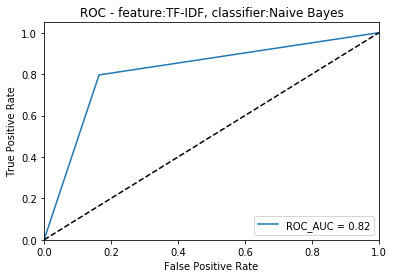

In [78]:
fpr, tpr, _ = roc_curve(Test_Y, predictions_NB)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC_AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC - feature:TF-IDF, classifier:Naive Bayes')
plt.show()


###SVM 

In [136]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
#print(type(Test_X_Tfidf.shape))
#print(type(predictions_SVM))
#print(type(Test_Y))
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  81.89999999999999


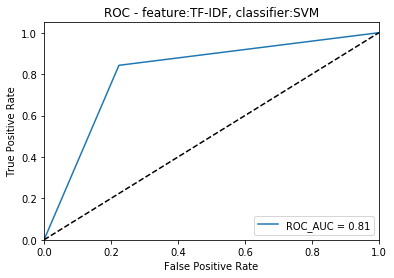

In [0]:
fpr, tpr, _ = roc_curve(Test_Y, predictions_SVM)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC_AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC - feature:TF-IDF, classifier:SVM')
plt.show()

### LDA 

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Classifier - Algorithm - LDA
# fit the training dataset on the classifier
LDA = LinearDiscriminantAnalysis()
LDA.fit(Train_X_Tfidf.todense(), Train_Y)  
# predict the labels on validation dataset
predictions_LDA = LDA.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("LDA Accuracy Score -> ",accuracy_score(predictions_LDA, Test_Y)*100)


LDA Accuracy Score ->  66.8


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


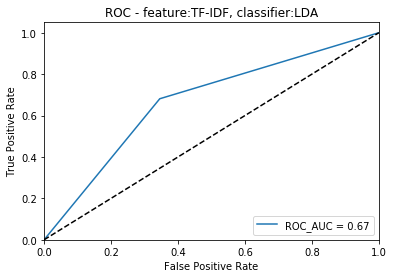

In [0]:
fpr, tpr, _ = roc_curve(Test_Y, predictions_LDA )
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC_AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC - feature:TF-IDF, classifier:LDA')
plt.show()

## Prof. Stamp Review Inference

In [0]:
f = open("StampReview_label.txt", "r") 
labels = ["Negative", "Positive"]
sentences = []
sentiments = []
for line in f.readlines():
  line = line.rstrip()
  sentiments.append(line.split('@')[0])
  sentences.append(line.split('@')[1])
print(sentiments[0], sentences[0])

1 Excellent knowledge and teaching strategies. Good use of previous student work as practical examples for the applications.


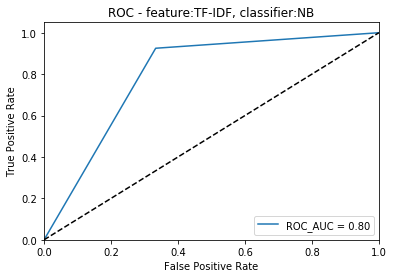

In [82]:
#predictions_stamp=SVM.predict(Tfidf_vect.transform(sentences))
predictions_stamp=Naive.predict(Tfidf_vect.transform(sentences))
GT_Y = Encoder.fit_transform(sentiments)
fpr, tpr, _ = roc_curve(GT_Y, predictions_stamp)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC_AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC - feature:TF-IDF, classifier:NB')
plt.show()

cm = confusion_matrix(GT_Y, predictions_stamp)



In [0]:
cm = confusion_matrix(GT_Y, predictions_stamp)
#print(cm)
print("TN=%d| FP=%d" % (cm[0][0],cm[0][1]))
print("FN=%d| TP=%d" % (cm[1][0],cm[1][1]))
FPs=[]
FNs=[]
for i in range(len(GT_Y)):
  if GT_Y[i] != predictions_stamp[i]:
    if GT_Y[i]==0:
      FPs.append(sentences[i])
    else:
      FNs.append(sentences[i])
print("\nFalse Positives\n=================")
print('\n'.join(FPs))
print("\nFalse Negatives\n=================")
print('\n'.join(FNs))


TN=5| FP=8
FN=4| TP=38

False Positives
This class was almost overwhelming in terms of the amount of time it demanded, certainly for the number of credits it's worth.
More jokes!
Please give lesser homework.
Homework is very intellectually challenging.
Due to the challenging assignments, CS-265 becomes the only subject, other subjects get neglected.
Too much homework!
Assignment in which we had to create a virus was really tough.
To sum it up, the book really, really sucked.

False Negatives
I like your different T-shirts
Knows his stuff. Some funny jokes. Kinda boring. Some lame jokes.
I would have professor teach all of my classes, if possible!
He seems excited to teach the subject. Lectures are not boring.


# [3] Feature: Word2Vec (Context-free Word Embeddings)


*   SVM Test Set Accuracy = 63%
*   Prof. Stamp Review Inference Accuracy = 68% 



In [83]:
!pip install embedding-as-service

     |████████████████████████████████| 143kB 2.7MB/s 
     |████████████████████████████████| 109.2MB 82kB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 1.0MB 23.0MB/s 
     |████████████████████████████████| 317kB 64.0MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 17.3MB 46.1MB/s 
     |████████████████████████████████| 71kB 12.8MB/s 
     |████████████████████████████████| 491kB 52.6MB/s 
     |████████████████████████████████| 3.2MB 47.1MB/s 
  Created wheel for smart-open: filename=smart_open-1.8.4-cp36-none-any.whl size=68202 sha256=0993d94a73aca30ef1243c0894f1f946f4307708b499af0a1ee9b59f3e90371d
  Stored in directory: /root/.cache/pip/wheels/5f/ea/fb/5b1a947b369724063b2617011f1540c44eb00e28c3d2ca8692
Successfully built smart-open
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requir

In [0]:
from embedding_as_service.text.encode import Encoder

In [3]:
en = Encoder(embedding='word2vec', model='google_news_300', download=True)

  0%|          | 4764/3000000 [00:00<01:02, 47637.21it/s]

Loading Model (this might take few minutes).....


100%|██████████| 3000000/3000000 [01:23<00:00, 36019.03it/s]

Model loaded Successfully !


In [0]:
Train_word2vec = en.encode(texts=Train_X.tolist())
#print(Train_X.tolist())
Test_word2vec = en.encode(texts=Test_X.tolist())

In [87]:
Train_word2vec.shape

(1000, 128, 300)

In [15]:
nsamples, nx, ny = Train_word2vec.shape
Train_word2vec_X = Train_word2vec.reshape((nsamples,nx*ny))
Test_word2vec_X = Test_word2vec.reshape((nsamples,nx*ny))
print(Train_word2vec_X.shape)

(1000, 38400)


## SVM

In [16]:
# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
import time
start_t=time.time()
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_word2vec_X ,Train_Y)
end_t=time.time()
print("training took = %.1f(min)" % ((end_t - start_t)/60.))
# predict the labels on validation dataset
start_t=time.time()
predictions_SVM = SVM.predict(Test_word2vec_X)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)
end_t=time.time()
print("inference took = %.1f(min)" % ((end_t - start_t)/60.))

training took = 1.2(min)
SVM Accuracy Score ->  60.4
inference took = 1.2(min)


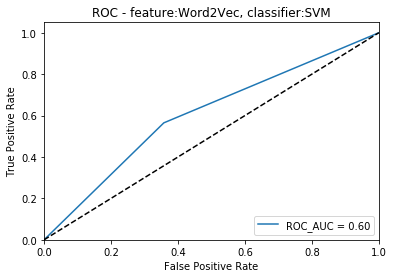

In [17]:
fpr, tpr, _ = roc_curve(Test_Y, predictions_SVM)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC_AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC - feature:Word2Vec, classifier:SVM')
plt.show()

In [18]:
pred_sentences = [
  "That movie was absolutely awful",
  "The acting was a bit lacking",
  "The film was creative and surprising",
  "Absolutely fantastic!"
]
#vectors = en.encode(texts=['hello aman', 'how are you?'], max_seq_length=256)
def SVM_prediction(in_sentences):
  vectors=en.encode(texts=in_sentences)
  nsamples, nx, ny = vectors.shape
  embeddings = vectors.reshape((nsamples,nx*ny))
  labels = ["Negative", "Positive"]
  predictions=SVM.predict(embeddings)
  return [(sentence, labels[prediction]) for sentence, prediction in zip(in_sentences, predictions)]
svm=SVM_prediction(pred_sentences)
for s in svm:
  print (s)

('That movie was absolutely awful', 'Negative')
('The acting was a bit lacking', 'Negative')
('The film was creative and surprising', 'Positive')
('Absolutely fantastic!', 'Positive')


## Prof. Stamp Review Inference

In [0]:
f = open("StampReview_label.txt", "r") 
labels = ["Negative", "Positive"]
sentences = []
sentiments = []
for line in f.readlines():
  line = line.rstrip()
  sentiments.append(line.split('@')[0])
  sentences.append(line.split('@')[1])
sentiments=np.array(sentiments, dtype=int)


(55, 38400)


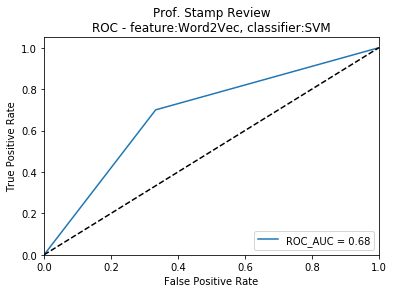

In [24]:
#predictions_stamp=SVM.predict(Tfidf_vect.transform(sentences))
word2vec = en.encode(texts=sentences)
nsamples, nx, ny = word2vec.shape
Train_word2vec_X = word2vec.reshape((nsamples,nx*ny))
word2vec_X = word2vec.reshape((nsamples,nx*ny))
print(word2vec_X.shape)

predictions_stamp=SVM.predict(word2vec_X)
GT_Y = sentiments
fpr, tpr, _ = roc_curve(GT_Y, predictions_stamp)
roc_auc = auc(fpr, tpr)
plt.plot(fpr,tpr,label='ROC_AUC = %0.2f' % roc_auc)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Prof. Stamp Review\nROC - feature:Word2Vec, classifier:SVM')
plt.show()


In [25]:
cm = confusion_matrix(GT_Y, predictions_stamp)
#print(cm)
print("TN=%d| FP=%d" % (cm[0][0],cm[0][1]))
print("FN=%d| TP=%d" % (cm[1][0],cm[1][1]))
FPs=[]
FNs=[]
for i in range(len(GT_Y)):
  if GT_Y[i] != predictions_stamp[i]:
    if GT_Y[i]==0:
      FPs.append(sentences[i])
    else:
      FNs.append(sentences[i])
print("\nFalse Positives\n=================")
print('\n'.join(FPs))
print("\nFalse Negatives\n=================")
print('\n'.join(FNs))


TN=10| FP=5
FN=12| TP=28

False Positives
More jokes!
Homework is very intellectually challenging.
Due to the challenging assignments, CS-265 becomes the only subject, other subjects get neglected.
Assignment in which we had to create a virus was really tough.
Class is too short---make it 2 semesters.

False Negatives
Dr. Stamp made complex concepts simple. The teaching method is very good.
You are awesome Prof Stamp.
You make difficult things look easy. I like the surprise of homeworks.
You are awesome.
I really look forward to his classes. He makes the class interesting with good examples.
I would have professor teach all of my classes, if possible!
Awesome teacher, takes otherwise complicated subject and makes it super simple. Great jokes! One of the few classes I look forward to attending. Don't change a thing!
I seldom have a professor who can teach material in such a memorable and interesting way.
I could learn a lot in this class.
Powerpoints are very effective and the professor